<a href="https://colab.research.google.com/github/kallepalomaki/cyber-ml/blob/main/cyber.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget "https://zenodo.org/record/6463389/files/ALLFLOWMETER_HIKARI2021.csv.zip"
!unzip ALLFLOWMETER_HIKARI2021.csv.zip

--2022-12-08 14:55:09--  https://zenodo.org/record/6463389/files/ALLFLOWMETER_HIKARI2021.csv.zip
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68403081 (65M) [application/octet-stream]
Saving to: ‘ALLFLOWMETER_HIKARI2021.csv.zip’

ALLFLOWMETER_HIKARI 100%[===================>]  65.23M   315KB/s    in 3m 29s  

2022-12-08 14:58:41 (319 KB/s) - ‘ALLFLOWMETER_HIKARI2021.csv.zip’ saved [68403081/68403081]

Archive:  ALLFLOWMETER_HIKARI2021.csv.zip
  inflating: ALLFLOWMETER_HIKARI2021.csv  


In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
from datetime import datetime


In [3]:
#!unzip ALLFLOWMETER_HIKARI2021.csv.zip.1
df=pd.read_csv('ALLFLOWMETER_HIKARI2021.csv')


In [4]:
df.shape

(555278, 88)

In [5]:
targets=df['Label'].values
inputs=df.drop(['uid', 'originp', 'originh', 'responh', 'responp', 'traffic_category','Label'],axis=1)

#from sklearn.datasets import load_breast_cancer

# load the data
#data = load_breast_cancer()

#inputs=data.data
#targets=data.target

In [6]:
#plt.plot(inputs[:,13])
#np.median(inputs[:,13])

In [7]:
#plt.plot(np.log(inputs[:,79]+1))
#plt.plot(inputs[:,77])
#plt.plot(np.log(inputs[:,79]+1))

In [8]:
#np_zeros.shape

In [9]:
scaler=StandardScaler()
scaler.fit(inputs)
inputs=scaler.transform(inputs)

In [10]:
inputs=inputs[:,2:]
inputs.shape

(555278, 79)

In [11]:
input_means=np.mean(inputs, axis=0)
input_std=np.std(inputs,axis=0)

1.2605758552224774e-17
-0.2153005507797462


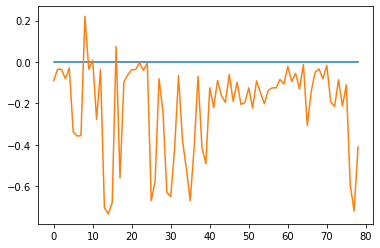

In [12]:
input_median=np.median(inputs, axis=0)
import matplotlib.pyplot as plt
plt.plot(input_means)
plt.plot(input_median)
print(np.mean(input_means))
print(np.mean(input_median))

14
-0.7340426741704812
-0.7204803747657283 -0.7204803747657283 2.948235772336147e-17


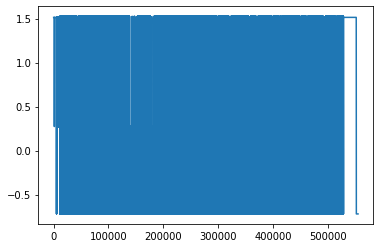

In [13]:
print(np.argmin(input_median))
print(np.min(input_median))
print(input_median[77], np.median(inputs[:,77]), np.mean(inputs[:,77]))
plt.plot(inputs[:,77])

In [14]:
inputs, targets=shuffle(inputs, targets)
train_len=int(len(targets)*0.8)

In [15]:
train_inputs=torch.from_numpy(inputs[:train_len].astype(np.float32))
test_inputs=torch.from_numpy(inputs[train_len:].astype(np.float32))

#train_targets=torch.from_numpy(targets[:train_len])
#test_targets=torch.from_numpy(targets[train_len:])

In [16]:
train_targets=torch.from_numpy(targets[:train_len].astype(np.float32).reshape(-1,1))
test_targets=torch.from_numpy(targets[train_len:].astype(np.float32).reshape(-1,1))

In [17]:
D=inputs.shape[1]

In [18]:
class Model(nn.Module):
  def __init__(self, D, num_hidden=512):
    super(Model, self).__init__()
    self.D=D

    self.linear_stack = nn.Sequential(
            nn.Linear(D, num_hidden),
            #nn.Conv1d(D,num_hidden, kernel_size=3),
            nn.ReLU(),
            nn.Linear(num_hidden,num_hidden),
            #nn.Conv1d(D,num_hidden, kernel_size=3),
            nn.ReLU(),
            nn.Linear(num_hidden,num_hidden),
            #nn.Conv1d(D,num_hidden, kernel_size=3),
            nn.ReLU(),
            nn.Linear(num_hidden, 1),
        )
    
  def forward(self, input_data):   
    logits=self.linear_stack(input_data)
    return logits

In [19]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [20]:
model=Model(D=D, num_hidden=100)
model.to(device)

Model(
  (linear_stack): Sequential(
    (0): Linear(in_features=79, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [21]:
criterion=nn.BCEWithLogitsLoss()  #MSELoss()# CrossEntropyLoss() #nn.BCEWithLogitsLoss() #nn.CrossEntropyLoss() #BCELoss #nn.BCEWithLogitsLoss
optimizer=torch.optim.Adam(model.parameters())

In [22]:
train_data=TensorDataset(train_inputs, train_targets)
test_data=TensorDataset(test_inputs, test_targets)
batch_size=512
train_loader=DataLoader(dataset=train_data,
                        batch_size=batch_size,
                        shuffle=False)
test_loader=DataLoader(dataset=test_data,
                        batch_size=batch_size,
                        shuffle=False)

In [23]:
def train(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses=np.zeros(epochs)
  test_losses=np.zeros(epochs)
  for it in range(epochs):
    t0=datetime.now()
    train_loss=[]
    for i_inputs, t_targets in train_loader:
      i_inputs, t_targets=i_inputs.to(device), t_targets.to(device)
      model.zero_grad()
      pred=model(i_inputs)
      #print(pred_ratings.shape, targets.shape)
      loss=criterion(pred, t_targets.reshape(-1,1))
      loss.backward()
      optimizer.step()
      train_loss.append(loss.item())
    train_losses[it]=np.mean(train_loss)
    test_loss=[]  
    for i_inputs, t_targets in test_loader:
      i_inputs, t_targets=i_inputs.to(device), t_targets.to(device)
      model.zero_grad()
      pred=model(i_inputs)
      loss=criterion(pred, t_targets.reshape(-1,1))
      test_loss.append(loss.item())
    test_losses[it]=np.mean(test_loss)
    print("iteration: ", it, "/", epochs, " train loss: ", train_losses[it], "test loss: ", test_losses[it])
  
  return train_losses, test_losses 

In [24]:
train_losses, test_losses=train(model, criterion, optimizer, train_loader, test_loader, 40)

iteration:  0 / 40  train loss:  0.14175391379177296 test loss:  0.12940926932244806
iteration:  1 / 40  train loss:  0.12638309928438357 test loss:  0.12903767570097874
iteration:  2 / 40  train loss:  0.12558493654196437 test loss:  0.12839018440191646
iteration:  3 / 40  train loss:  0.1252236050394823 test loss:  0.12795212157585653
iteration:  4 / 40  train loss:  0.1250347347183299 test loss:  0.12733757499313575
iteration:  5 / 40  train loss:  0.12484145421998293 test loss:  0.1277435403746394
iteration:  6 / 40  train loss:  0.12467365223519539 test loss:  0.12729840852697874
iteration:  7 / 40  train loss:  0.12452214582896177 test loss:  0.12789281821607995
iteration:  8 / 40  train loss:  0.12449270867085951 test loss:  0.12679845104981127
iteration:  9 / 40  train loss:  0.12431323832149879 test loss:  0.12677107758236372
iteration:  10 / 40  train loss:  0.12420793299988118 test loss:  0.12673395875549537
iteration:  11 / 40  train loss:  0.124105554074049 test loss:  0.1

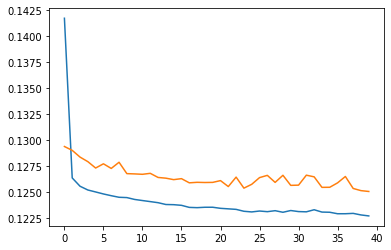

In [25]:
plt.plot(train_losses)
plt.plot(test_losses)

In [26]:
train_list=[]
test_list=[]
for i_inputs, t_targets in train_loader:
  i_inputs, t_targets=i_inputs.to(device), t_targets.to(device)

  pred_train = model(i_inputs)
  pred_train = (pred_train.detach().cpu().numpy() > 0.5)
  train_list.append(np.mean(t_targets.detach().cpu().numpy() == pred_train))
  #print(train_acc)
#  pred_test = model(X_test)
#  p_test = (p_test.numpy() > 0)
#  test_acc = np.mean(y_test.numpy() == p_test)
#print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

for i_inputs, t_targets in test_loader:
  i_inputs, t_targets=i_inputs.to(device), t_targets.to(device)

  pred_test = model(i_inputs)
  pred_test = (pred_test.detach().cpu().numpy() > 0.5)
  test_list.append(np.mean(t_targets.detach().cpu().numpy() == pred_test))
  #print(train_acc)
#  pred_test = model(X_test)
#  p_test = (p_test.numpy() > 0)
#  test_acc = np.mean(y_test.numpy() == p_test)
#print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")


In [27]:
print(np.mean(np.array(train_list)))
print(np.mean(np.array(test_list)))

0.9327572341988378
0.931332743226601
